In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_results(pil_img, prob, boxes,text):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, linewidth=3))

        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [3]:
from transformers import DetrForObjectDetection , DetrImageProcessor
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from PIL import Image
image = Image.open("../examp.png")

annotations = [
    {
    "image_id" : 0,
    "annotations" : [{"id": 0, 
                     "image_id" : 0,
                     "category_id" : 71,
                     "segmentation" : None,
                     "area" : None, 
                     "bbox": [64,97,445,242],
                     "iscrowd" : 0},
                    ]
    }
]

In [5]:
inputs = processor.preprocess(image,annotations, return_tensors="pt")
labels = [{k: v.to(device) for k, v in inputs["labels"][0].items()}]
pixel_values = inputs["pixel_values"].to(device)
pixel_values.requires_grad = True
pixel_mask = inputs["pixel_mask"].to(device)


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [6]:
outputs = model(pixel_values, pixel_mask, labels=labels)
model.zero_grad()
outputs.loss.backward()

In [7]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected bench with confidence 0.999 at location [61.37, 98.49, 511.75, 343.61]


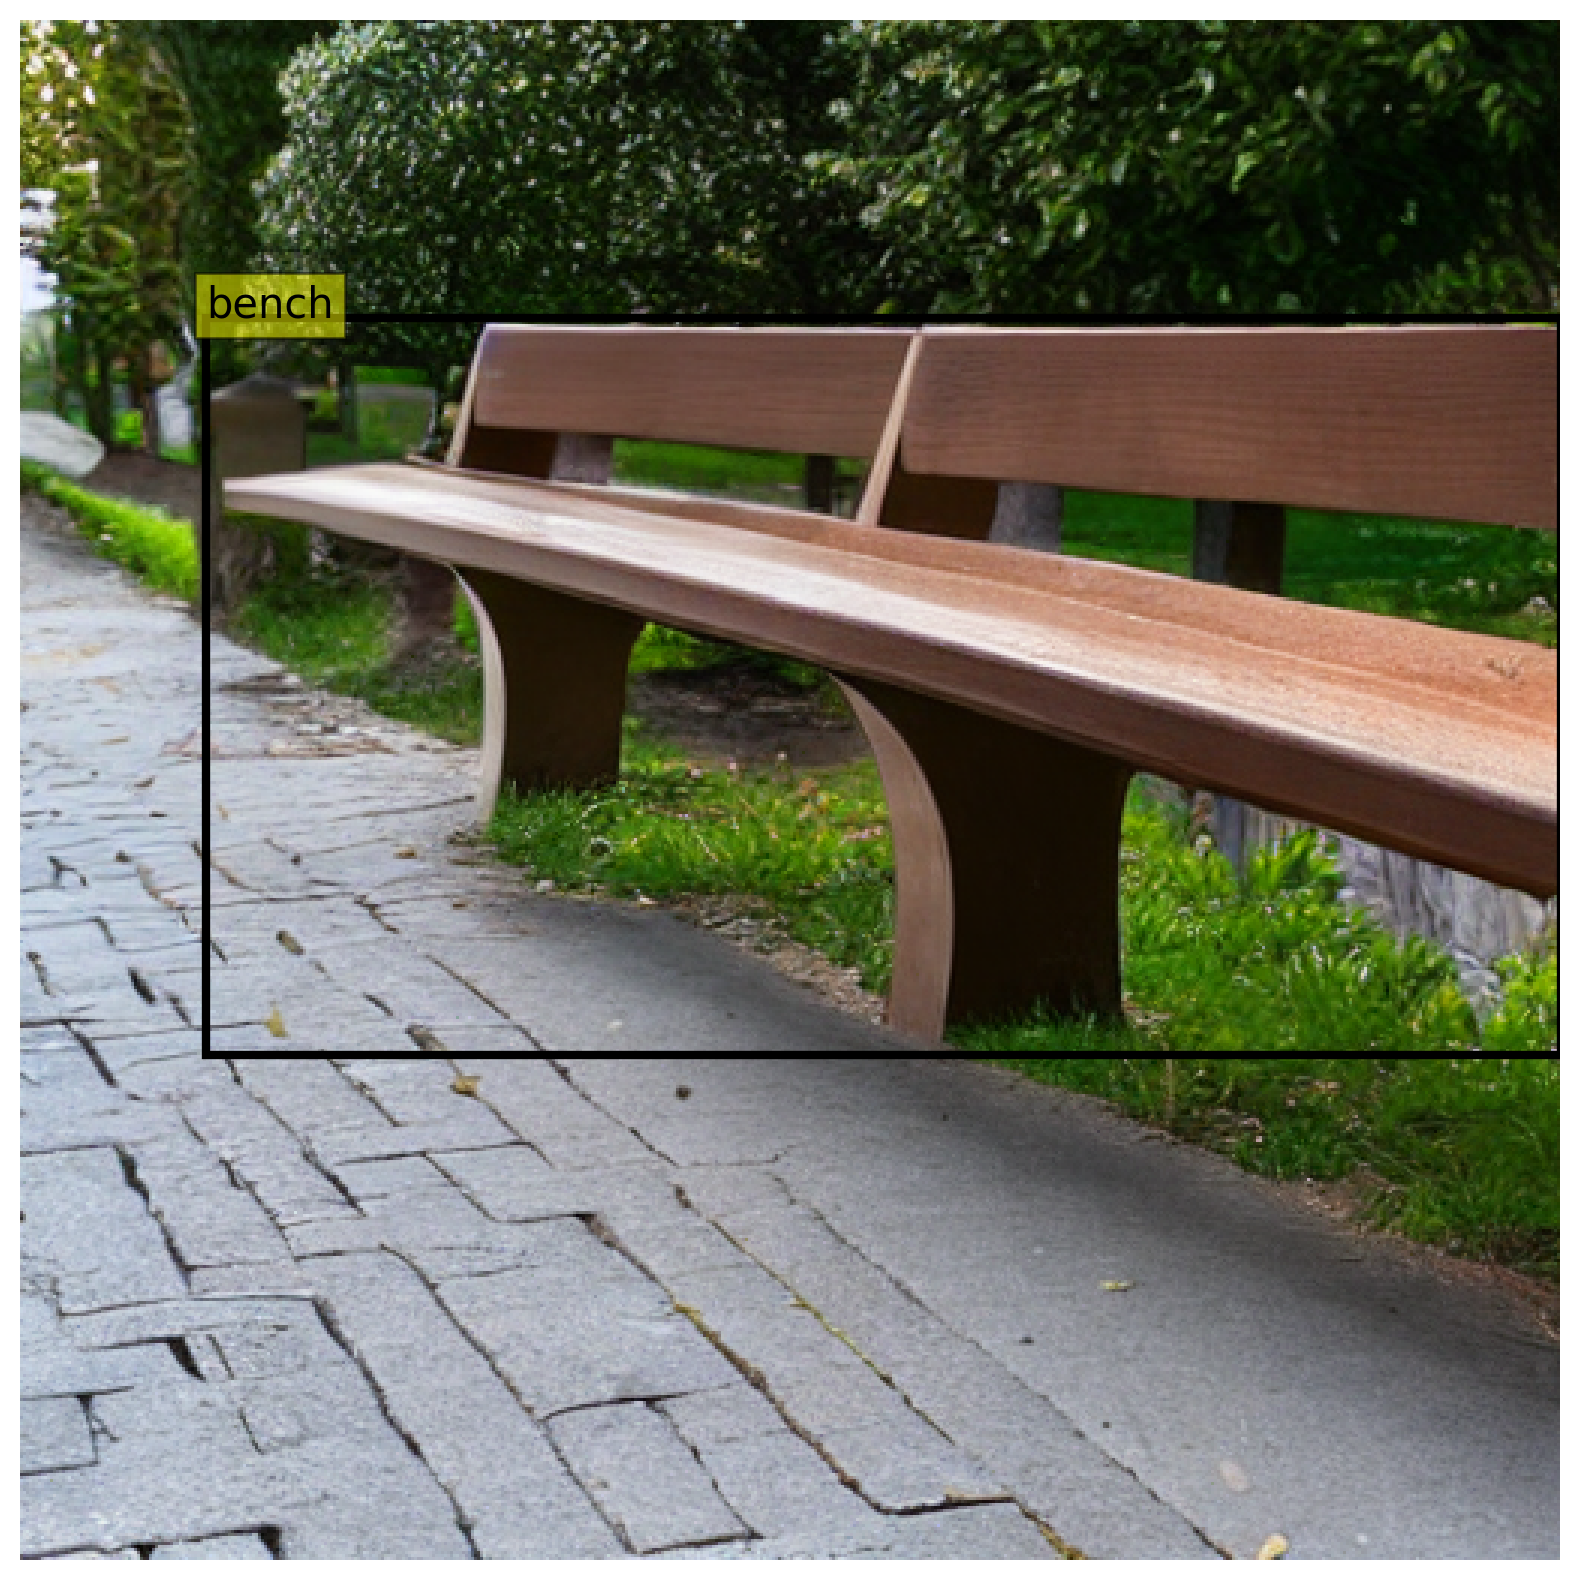

In [8]:
text = model.config.id2label[label.item()]
plot_results(image,results["scores"],results["boxes"], text )

Detected boat with confidence 0.991 at location [65.62, 99.3, 511.91, 283.76]


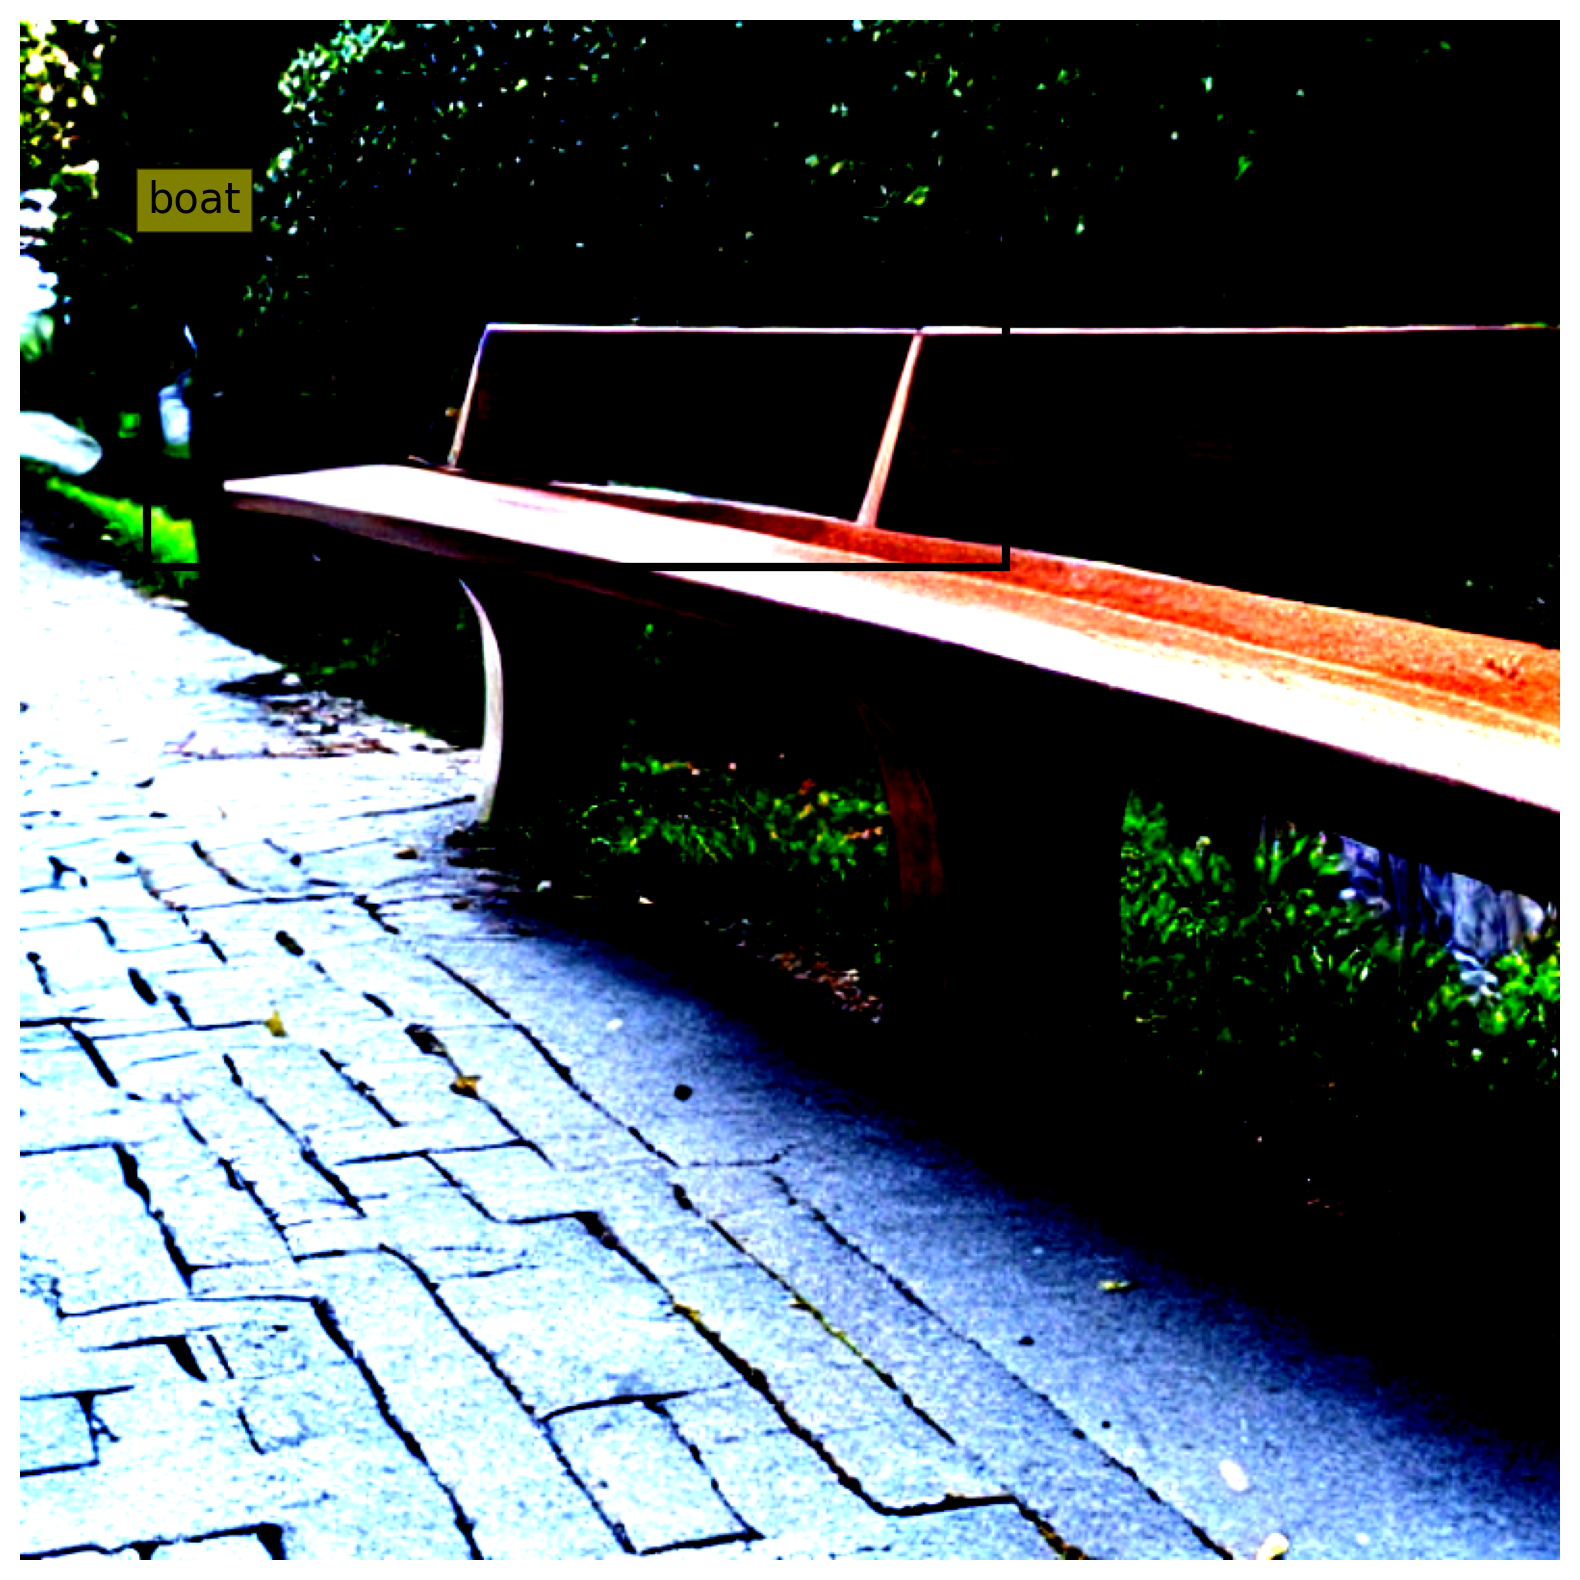

In [9]:
image_grad = pixel_values.grad
image_grad_sign = image_grad.sign()
perturbed_image = pixel_values + 0.003 * image_grad_sign
perturbed_image = torch.clamp(perturbed_image, 0, 1)

inputs_ = processor.preprocess(perturbed_image, return_tensors="pt", do_rescale=False).to(device)
outputs_ = model(**inputs_)

target_sizes = torch.tensor([image.size[::-1]])
results_ = processor.post_process_object_detection(outputs_, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results_["scores"], results_["labels"], results_["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    text = model.config.id2label[label.item()]
    final_image = perturbed_image.squeeze().permute(1,2,0).detach().cpu().numpy()
    plot_results(final_image,results_["scores"],results_["boxes"], text )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


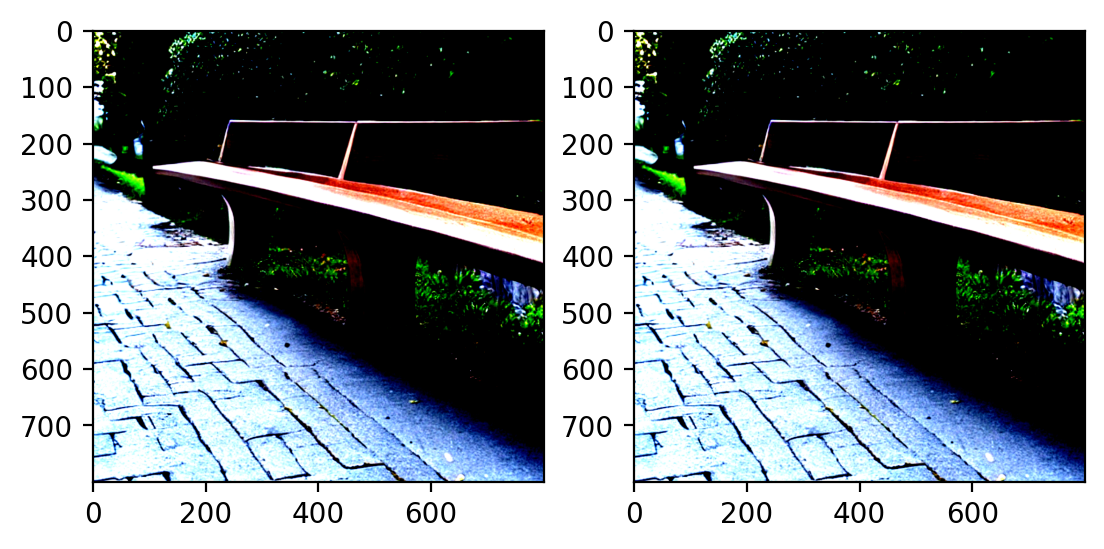

In [10]:
plt.subplot(1,2,1)
plt.imshow(perturbed_image.detach().cpu().squeeze().permute(1,2,0).numpy())

plt.subplot(1,2,2)
plt.imshow(pixel_values.detach().cpu().squeeze().permute(1,2,0).numpy())
plt.show()